In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer


import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [133]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [134]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Data Acquisition

In [135]:
df = pd.read_csv("train.csv")

In [136]:
df.sample(5)

,id,title,author,text,label
18854,18854,Communist to Host Event at UC Berkeley On Driv...,Tom Ciccotta,A discussion event on driving conservative spe...,0
19694,19694,"Introducing The Run-Up, Our New Election Podca...",Michael Barbaro,It’s three months until Election Day. To guide...,0
9100,9100,Can the G.O.P. Senate Majority Survive Donald ...,Robert Draper,"On a Sunday morning in early June, Senator Mar...",0
3920,3920,Milky Way galaxy mapped in incredible detail,NaN,"Sky & Telescope Wed, 26 Oct 2016 20:05 UTC Ast...",1
9968,9968,End of the Line for Penn Station’s Departure B...,James Barron,The departure board at Pennsylvania Station in...,0


id: unique id for a news article 

title: title of the news article

author: Author of the news article

text: text of the newss article (could be incomplete)

label: 
1=Fake news
0: Real news

In [137]:
df.shape

(20800, 5)

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [139]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [140]:
df.describe()

,id,label
count,20800.000000,20800.000000
mean,10399.500000,0.500625
std,6004.587135,0.500012
min,0.000000,0.000000
25%,5199.750000,0.000000
50%,10399.500000,1.000000
75%,15599.250000,1.000000
max,20799.000000,1.000000


In [141]:
(df["label"] == 0).sum()/df.shape[0]

0.499375

In [142]:
(df["label"] == 1).sum()/df.shape[0]

0.500625

# Data Preprocessing

In [143]:
#imputer = SimpleImputer(strategy= "constant", fill_value="")
#imputer.fit(df)
#df_imp = imputer.transform(df)
#df = pd.DataFrame(df_imp, columns=df.columns, index = df.index)

df = df.fillna("")

In [144]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [145]:
# Add columns: title and author 

df["content"] =  df["author"] + " " + df["title"]
df.drop(columns = ["author" , "title", "id", "text"], axis=1, inplace=True)

In [146]:
np.dtype(df["content"])

dtype('O')

In [147]:
ps = PorterStemmer()

def stemming(content):
    stemmed_content = re.sub("[^a-zA-Z]", " ",  content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [ps.stem(word) for word in stemmed_content if not word in stopwords.words("english")]
    stemmed_content = " ".join(stemmed_content)
    return stemmed_content

In [148]:
df["content"] =  df["content"].apply(stemming)
#X_train["text"]  = X_train["text"].apply(stemming)

In [149]:
X = df["content"].values
y = df["label"].values
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.2, random_state=16, stratify=y)

In [150]:
tf_idf = TfidfVectorizer()

tf_idf.fit(X_train)
X_train = tf_idf.transform(X_train)

In [151]:
print(X_train)

  (0, 315)	0.3788500716558785
  (0, 424)	0.25917581133408707
  (0, 4600)	0.32961831318057183
  (0, 10030)	0.3413191738566585
  (0, 10503)	0.2825121063616428
  (0, 10998)	0.2922394761752474
  (0, 11905)	0.24754643521382835
  (0, 12285)	0.32846415492609354
  (0, 13478)	0.2790257869289131
  (0, 14215)	0.14477518169040454
  (0, 14977)	0.2550098169285347
  (0, 15334)	0.256755372154665
  (1, 1292)	0.27382068220132466
  (1, 4692)	0.252800429897782
  (1, 6135)	0.2675043785460936
  (1, 7495)	0.3233175239328102
  (1, 8308)	0.22987609861848354
  (1, 10969)	0.34039794429176395
  (1, 11045)	0.32135784502022396
  (1, 11435)	0.32981119837585415
  (1, 13398)	0.38377117691651463
  (1, 14782)	0.27980125042403303
  (1, 15300)	0.28052136197429023
  (2, 275)	0.28227678940353707
  (2, 344)	0.28581019652697187
  :	:
  (16637, 10951)	0.279710604356385
  (16637, 13478)	0.18777027998616466
  (16637, 14215)	0.09742639452883564
  (16637, 14242)	0.24046120147953692
  (16638, 642)	0.2965799567853293
  (16638, 1468)

# Model Buliding

## 1. Logistic Regression

In [152]:
lr_model = LogisticRegression()


In [153]:
lr_model.fit(X_train, y_train)

LogisticRegression()

In [154]:
X_train_pred = lr_model.predict(X_train)
train_accuracy = accuracy_score(X_train_pred, y_train)
train_accuracy

0.9865384615384616

### Cross validation

In [155]:
scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring="accuracy")

In [156]:
scores

array([0.97896635, 0.96905048, 0.96784856, 0.97836538, 0.97115385])

In [157]:
y_train_pred = cross_val_predict(lr_model, X_train, y_train, cv=5)

In [158]:
cnf_mat = confusion_matrix(y_train_pred, y_train)

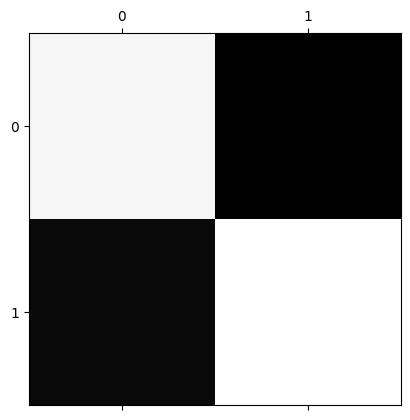

In [159]:
plt.matshow(cnf_mat, cmap= plt.cm.gray)

In [160]:
cnf_mat

array([[7942,   80],
       [ 368, 8250]], dtype=int64)

In [161]:
precision_score(y_train_pred, y_train)

0.9903961584633854

In [162]:
recall_score(y_train_pred, y_train)

0.9572986771872825

In [163]:
f1_score(y_train_pred, y_train)

0.9735662025017702

### On Test Data

In [164]:
print(X_val)

['rebecca diserio badass trump chairwoman shred michel hillari favorit spokesman'
 'norepli blogger com der postillon ein rger obama hat ber nacht mtlich atomcod verloren'
 'helen cooper eric schmitt jame matti trump choic defens favor work alli new york time'
 ...
 'eric lipton adam liptak foreign payment trump firm violat constitut suit claim new york time'
 'norepli blogger com alexand light presid elect trump new era unpredict await'
 'dan wright video show white helmet stage fake rescu syria']


In [165]:
X_val = tf_idf.transform(X_val)

In [166]:
y_val_pred = lr_model.predict(X_val)

In [167]:
accuracy_score(y_val_pred, y_val)

0.973798076923077

In [168]:
confusion_matrix(y_val_pred, y_val)

array([[1994,   26],
       [  83, 2057]], dtype=int64)

In [169]:
precision_score(y_val_pred, y_val)

0.9875180028804609

In [170]:
recall_score(y_val_pred, y_val)

0.961214953271028

In [171]:
f1_score(y_val_pred, y_val)

0.9741889651906228

## 2. SGDRgeressor

In [172]:
sgd_model = SGDClassifier(random_state=42)
sgd_model.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [173]:
X_train_pred = sgd_model.predict(X_train)
train_accuracy = accuracy_score(X_train_pred, y_train)
train_accuracy

0.9947716346153846

### Cross Validation Score

In [174]:
scores = cross_val_score(sgd_model, X_train, y_train, cv=5, scoring="accuracy")

In [175]:
scores

array([0.9921875 , 0.98617788, 0.98888221, 0.99188702, 0.98858173])

In [176]:
y_train_pred = cross_val_predict(sgd_model, X_train, y_train, cv=5)

In [177]:
confusion_matrix(y_train_pred, y_train)

array([[8190,   54],
       [ 120, 8276]], dtype=int64)

In [178]:
precision_score(y_train_pred, y_train)

0.9935174069627851

In [179]:
recall_score(y_train_pred, y_train)

0.985707479752263

In [181]:
f1_score(y_train_pred, y_train)

0.9895970345569771

#### On Test set

In [182]:
y_pred = sgd_model.predict(X_val)

In [183]:
confusion_matrix(y_pred, y_val)

array([[2047,   21],
       [  30, 2062]], dtype=int64)

In [184]:
f1_score(y_pred, y_val)

0.9877844311377245

In [185]:
accuracy_score(y_pred, y_val)

0.9877403846153846

In [186]:
precision_score(y_pred, y_val)

0.9899183869419107

# On new dataset

In [187]:
df = pd.read_csv("test.csv")

In [188]:
df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [189]:
df = df.fillna("")
df["content"] =  df["author"] + " " + df["title"]
df["content"] =  df["content"].apply(stemming)

In [191]:
X = df["content"].values


In [193]:
X = tf_idf.transform(X)

In [194]:
X

<5200x15596 sparse matrix of type '<class 'numpy.float64'>'
	with 50383 stored elements in Compressed Sparse Row format>

In [195]:
y_pred = lr_model.predict(X)

array([0, 1, 1, ..., 0, 1, 0], dtype=int64)

In [199]:
type(y_pred)

numpy.ndarray

In [201]:
y = pd.DataFrame(y_pred)
df["y"] = y

In [205]:
df[["y", "id"]].to_csv("submit.csv", index=False)